# Preparation

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import random

# "m" is the number of components
# "k" is the index of each component
# "x" is the list of parameter (x=[mu_k,rho_k,lambda_k,pi_k])

# The probability density function of MMoKJ for the parameter x=[mu_k,rho_k,lambda_k,pi_k] at the list of points Theta_i
def PDF(x,m,lis):
    pdf=np.full(len(lis),1-sum([x[3+4*k] for k in range(m)]))
    for k in range(m):
        each_pdf=np.array([1+(1-x[1+4*k]**2)/(1-x[1+4*k]*math.cos(x[2+4*k]))*(math.cos(lis[th]-x[0+4*k])-x[1+4*k]*math.cos(x[2+4*k]))/
            (1+x[1+4*k]**2-2*x[1+4*k]*math.cos(lis[th]-x[0+4*k]-x[2+4*k])) for th in range(len(lis))])
        pdf+=each_pdf*x[3+4*k]
    pdf=pdf/(2*math.pi)
    return pdf

# The probability density function of single Kato-Jones for the parameter x=[mu, rho, lambda, pi]
def eachPDF(x,lis):
    each_pdf=np.array([1+(1-x[1]**2)/(1-x[1]*math.cos(x[2]))*(math.cos(lis[th]-x[0])-x[1]*math.cos(x[2]))/(1+x[1]**2-2*x[1]*math.cos(lis[th]-x[0]-x[2])) for th in range(len(lis))])
    return each_pdf*x[3]/(2*math.pi)

# The probability density function of single Kato and-for the parameter x=[mu, gam, rho, lambda, pi]
def eachPDF2(x,lis):
    each_pdf=np.array([1+2*x[1]*(math.cos(lis[th]-x[0])-x[2]*math.cos(x[3]))/(1+x[2]**2-2*x[2]*math.cos(lis[th]-x[0]-x[3])) for th in range(len(lis))])
    return each_pdf*x[4]/(2*math.pi)

def flatPDF(x,lis):
    return np.array([x]*len(lis))/(2*math.pi)

# Drawing the histogram and the probability density function
def Drawing(x,m,lis,save=0,name=None):
    fig = plt.figure(dpi=300)
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.bar(bin_middle,lis,width=2*math.pi/numbin,alpha=0.2,color="black")
    # plot of MMoKJ
    ax2.plot(bin_middle,PDF(x,m,bin_middle),color="black",linewidth=3)
    # plot of each Kato and Jones
    for k in range(m):
        ax2.plot(bin_middle,eachPDF(np.array(x).reshape(m,4)[k],bin_middle),color="black",linewidth=2,linestyle="dashed")
    # plot of uniform distribution
    ax2.plot(bin_middle,[(1-sum([x[3+4*k] for k in range(m)]))/(2*math.pi)]*numbin,color="black",linewidth=2,linestyle="dashed")
    
    # axis label
    ax1.set_ylabel("Number of vehicle/15 min",size=15)
    ax2.set_ylabel("pdf",size=15)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='y', labelsize=15)
    # Conform the size of histogram to the summation of probability density function
    if numbin*ax1.get_ylim()[1]/(2*math.pi*sum(lis))<ax2.get_ylim()[1]:
        ax2.set_ylim(0,None)
        ax1.set_ylim(0,ax2.get_ylim()[1]*2*math.pi*sum(lis)/numbin)
    else:
        ax2.set_ylim(0,numbin*ax1.get_ylim()[1]/(2*math.pi*sum(lis)))
    
    plt.xticks([0,math.pi/2,math.pi,3*math.pi/2,2*math.pi])
    ax1.set_xlabel("Time of day (hours)",size=15)
    ax1.set_xticklabels(["0\n0","$\pi/2$\n6","$\pi$\n12","$3\pi/2$\n18","$2\pi$\n24"],fontsize=15)
    # save figure or not
    if save==0:
        plt.show()
    elif save==1:
        plt.savefig("{}.png".format(name),bbox_inches='tight', pad_inches=0.03)
        plt.close()        
    else:
        plt.savefig("{}.png".format(name),bbox_inches='tight', pad_inches=0.03)
        plt.show()
        
# ETM for the parameter x=[mu_k,rho_k,lambda_k,pi_k]
def ETM(x):
    # "gam" is the list of gamma_max for each component
    gams=[(1-x[1+4*k]**2)/(2*(1-x[1+4*k]*math.cos(x[2+4*k]))) for k in range(m)]
    # The moment of MMoKJ (right term of ETM)
    def coss(x,m,p):
        cossl=[x[3+4*k]*gams[k]*x[1+4*k]**(p-1)*math.cos(p*x[0+4*k]+(p-1)*x[2+4*k]) for k in range(m)]
        return sum(cossl)
    def sins(x,m,p):
        sinsl=[x[3+4*k]*gams[k]*x[1+4*k]**(p-1)*math.sin(p*x[0+4*k]+(p-1)*x[2+4*k]) for k in range(m)]
        return sum(sinsl)
    etm=sum([c**p*((cosl[p]-coss(x,m,p))**2+(sinl[p]-sins(x,m,p))**2) for p in range(1,q+1)])
    return etm

# The moment of MMoKJ (right term of ETM)
def rights(x,p):
    gams=[(1-x[1+4*k]**2)/(2*(1-x[1+4*k]*math.cos(x[2+4*k]))) for k in range(m)]
    cossl=[x[3+4*k]*gams[k]*x[1+4*k]**(p-1)*math.cos(p*x[0+4*k]+(p-1)*x[2+4*k]) for k in range(m)]
    sinsl=[x[3+4*k]*gams[k]*x[1+4*k]**(p-1)*math.sin(p*x[0+4*k]+(p-1)*x[2+4*k]) for k in range(m)]
    return [sum(cossl),sum(sinsl)]

# constraints of pi_k
def con(x):
    return 1-sum([x[3+4*k] for k in range(m)])
cons = {'type':'ineq', 'fun': con}

# index for columns of DataFrame
indexes=[]
for i in range(20):
    mu="mu{}".format(i+1)
    rho="rho{}".format(i+1)
    lam="lam{}".format(i+1)
    pi="pi{}".format(i+1)
    indexes.extend([mu,rho,lam,pi])
    
# log-likelihood function for list of data
def LogLH(x,m,lis):
    pdf=np.full(len(lis),1-sum([x[3+4*k] for k in range(m)]))
    for k in range(m):
        gam=(1-x[1+4*k]**2)/(1-x[1+4*k]*math.cos(x[2+4*k]))
        # rl is rho*cos(lambda)
        rl=x[1+4*k]*math.cos(x[2+4*k])
        # sqr is 1+rho**2
        sqr=1+x[1+4*k]**2
        # ml is mu+lambda
        ml=x[0+4*k]+x[2+4*k]
        each_pdf=np.array([(math.cos(lis[th]-x[0+4*k])-rl)/(sqr-2*x[1+4*k]*math.cos(lis[th]-ml)) for th in range(len(lis))])
        pdf=pdf+(each_pdf*gam+1)*x[3+4*k]
    pdf=pdf/(2*math.pi)
    if min(pdf)<1e-300:
        llf=-math.inf
    else:
        llf = sum([math.log(pdf[i]) for i in range(len(pdf))])
    return llf

# log-likelihood function for M-step, parameter is [mu_k, rho_k, lambda_k]
def LogLHem(x):
    pdf=np.full(len(angles),pi_k[-1])
    for k in range(m):
        gam=(1-x[1+3*k]**2)/(1-x[1+3*k]*math.cos(x[2+3*k]))
        rl=x[1+3*k]*math.cos(x[2+3*k])
        sqr=1+x[1+3*k]**2
        ml=x[0+3*k]+x[2+3*k]
        each_pdf=np.array([(math.cos(angles[th]-x[0+3*k])-rl)/(sqr-2*x[1+3*k]*math.cos(angles[th]-ml)) for th in range(len(angles))])
        pdf=pdf+(each_pdf*gam+1)*pi_k[k]
    pdf=pdf/(2*math.pi)
    if min(pdf)<1e-300: 
        llf=-math.inf
    else:
        llf=sum([math.log(pdf[i]) for i in range(len(pdf))])
    return -llf

# Integral of distribution function between theta1 and theta2
# x=[mu_k, rho_k, lambda_k, pi_k]
def Integ(theta1,theta2,x,m):
    # Distribution function for theta
    def disfun(theta,x):
        if x[2]<1e-5:
            ac=1/(2*math.pi)*(theta-x[0]+math.pi+2*x[1]*math.sin(theta-x[0]))
        else:            
            ac=1/(2*math.pi)*((1-x[1]*math.cos(x[3])/x[2])*(theta-x[0]+math.pi)+x[1]*math.sin(x[3])/x[2]*math.log((1+x[2]**2+2*x[2]*math.cos(x[3]))/(1+x[2]**2-2*x[2]*math.cos(theta-x[0]-x[3])))
                             +2*x[1]*math.cos(x[3])/x[2]*(math.atan((1+x[2])/(1-x[2])*math.tan((theta-x[0]-x[3])/2))-math.atan((1+x[2])/(1-x[2])/math.tan(x[3]/2))))
            if math.tan((theta-x[0]-x[3])/2)<1/math.tan(x[3]/2):
                ac+=x[1]*math.cos(x[3])/x[2]
        return ac*x[4]
    cdf=(1-sum([x[3+4*k] for k in range(m)]))*(theta2-theta1)/(2*math.pi)
    for k in range(m):
        kj=x[0+k*4:4+k*4]
        gam=(1-kj[1]**2)/(2*(1-kj[1]*math.cos(kj[2])))
        kj=[kj[0],gam,kj[1],kj[2],kj[3]]
        if theta1>kj[0]-math.pi and theta2<kj[0]+math.pi:
            cdf+=disfun(theta2,kj)-disfun(theta1,kj)
            continue
        elif theta2<kj[0]-math.pi:
            cdf+=disfun(theta2+2*math.pi,kj)-disfun(theta1+2*math.pi,kj)
            continue
        elif theta1>kj[0]+math.pi:
            cdf+=disfun(theta2-2*math.pi,kj)-disfun(theta1-2*math.pi,kj)
            continue
        elif theta1<kj[0]-math.pi and theta2>kj[0]-math.pi:
            cdf+=disfun(theta2,kj)+kj[4]-disfun(theta1+2*math.pi,kj)
            continue
        else:
            cdf+=disfun(theta2-2*math.pi,kj)+kj[4]-disfun(theta1,kj)
            continue
    return cdf



# Data generation

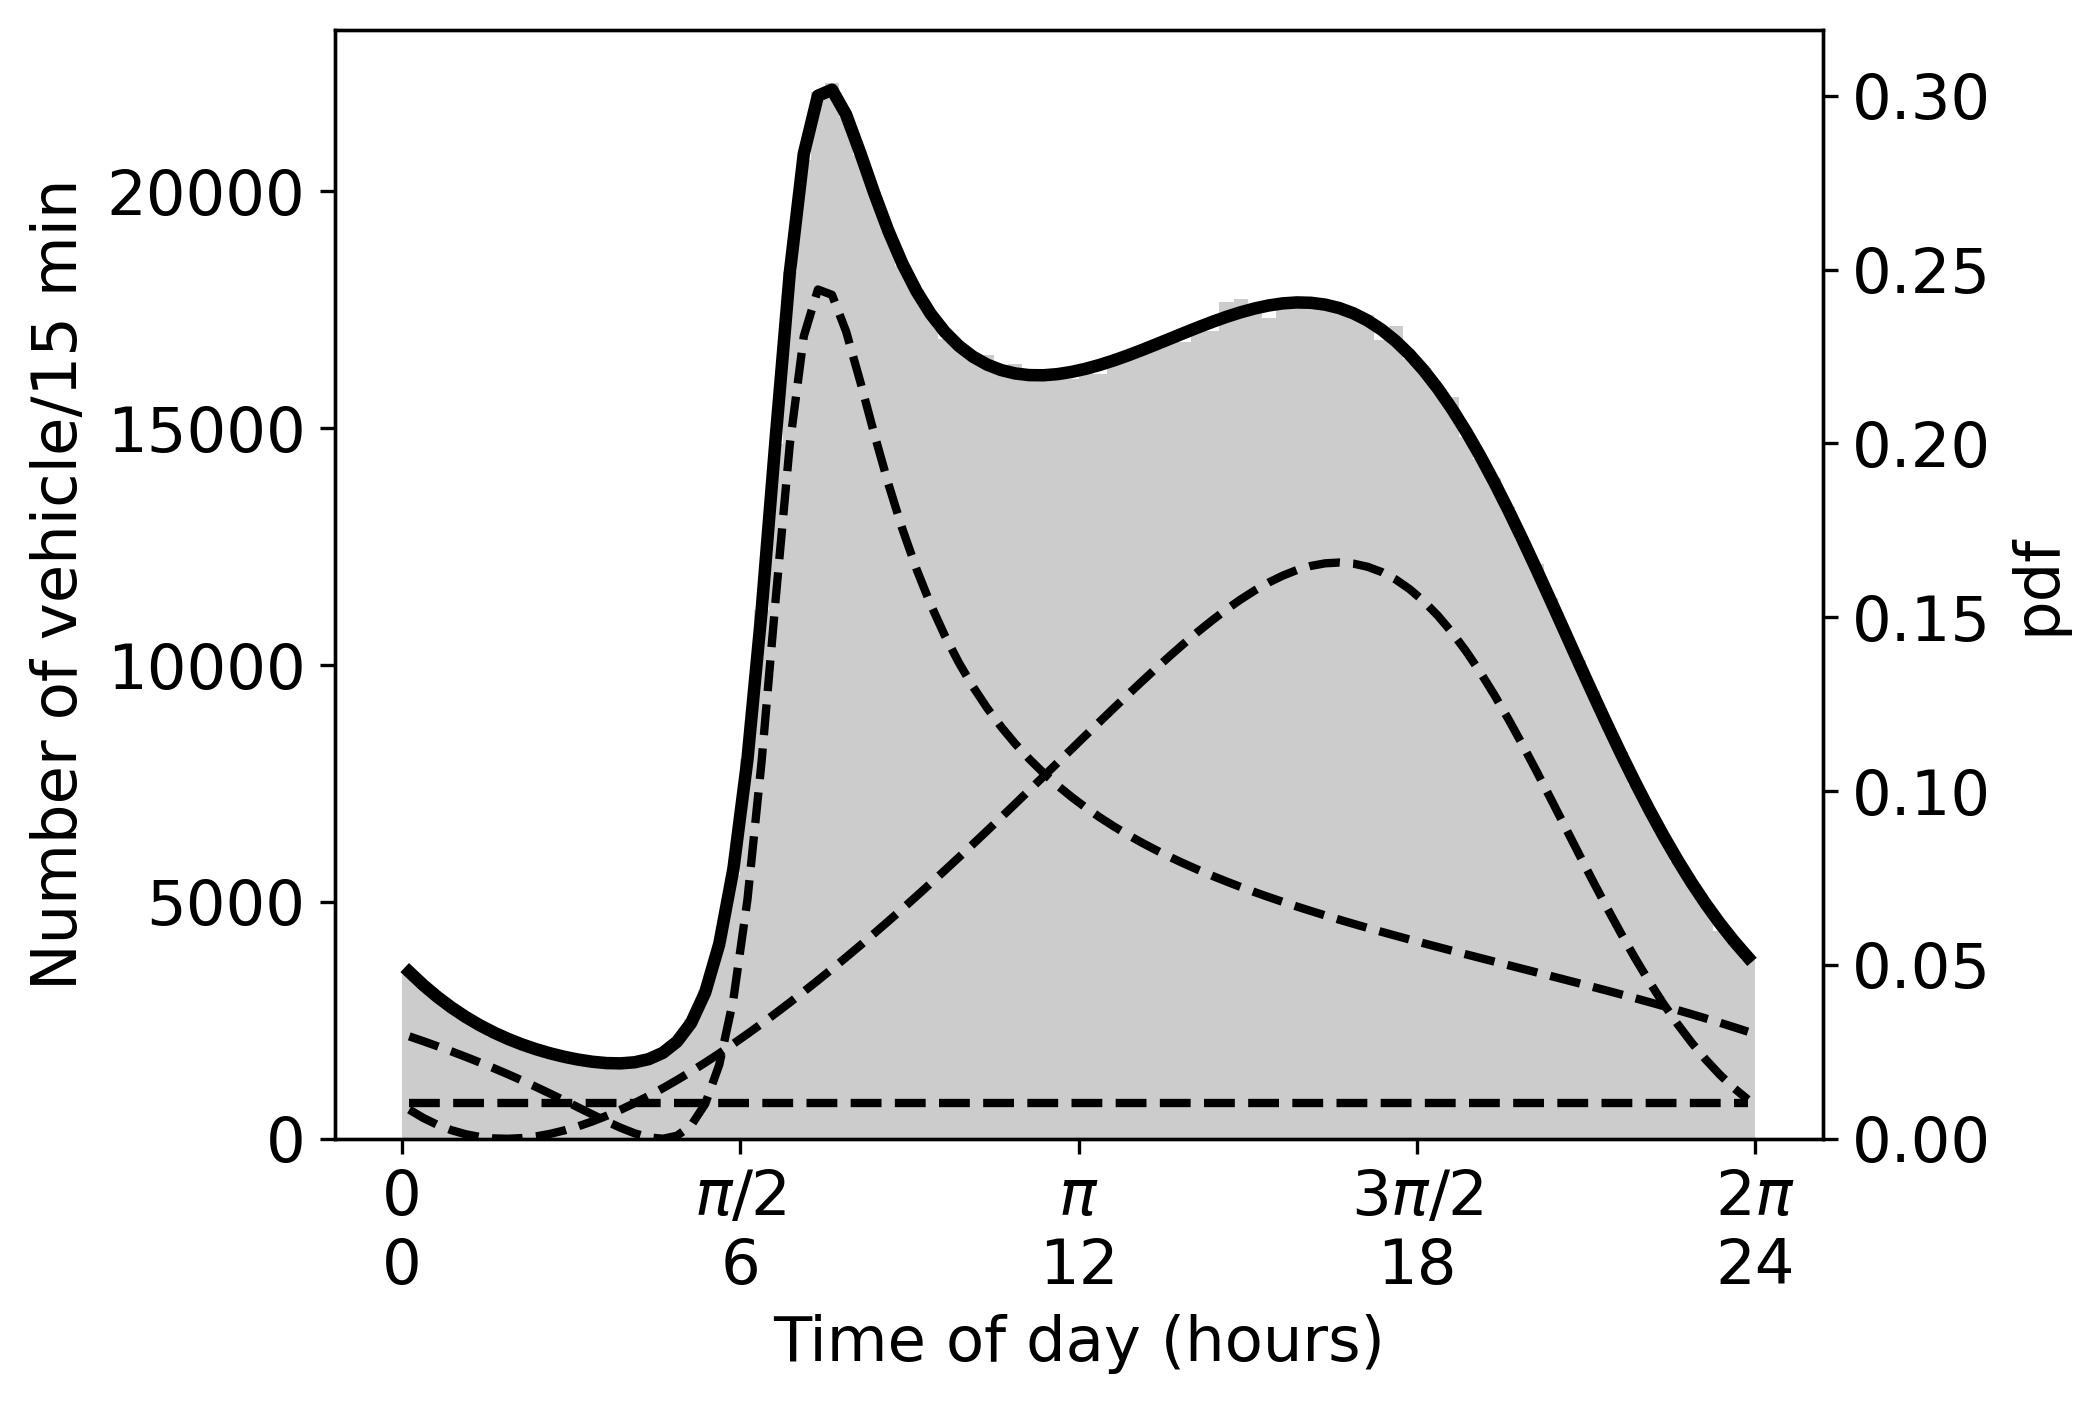

In [2]:
# numbin is the number of bins in [0, 2*pi)
numbin=96
c=0.9

m=2
q=2*m
bin_middle=[(i*2+1)*np.pi/numbin for i in range(numbin)]

# Generate random samples from the estimated parameters
resolution_of_cdf=1440
number_of_samples=1121262
minitus=np.linspace(0, 2*math.pi, resolution_of_cdf)

# This parameter is estimated from original data
parameter=[2.7572,0.7266,5.3136,0.4536,4.0107,0.1970,1.1895,0.4825]
cdfs=[Integ(0,minitus[i],parameter,m) for i in range(resolution_of_cdf)]
randoms=sorted([random.random() for i in range(number_of_samples)])
cdf_=1
angles=[]
for ran_ in range(number_of_samples):
    if randoms[ran_]>cdfs[cdf_]:
        cdf_+=1
    angle=(randoms[ran_]-cdfs[cdf_-1])/(cdfs[cdf_]-cdfs[cdf_-1])*2*math.pi/(resolution_of_cdf-1)+(cdf_-1)*2*math.pi/(resolution_of_cdf-1)
    angles.append(angle)


# count the number of data in each bin
angles_l=[0]*numbin

for ang_ in range(len(angles)):
    bins=int(angles[ang_]//(2*math.pi/numbin))
    if bins==numbin:
        angles_l[0]=angles_l[0]+1
    else:
        angles_l[bins]=angles_l[bins]+1
        
Drawing(parameter,m,angles_l)

# Parameter estimation

C:\Users\Nagasaki\AppData\Local\Temp\ipykernel_35300\1849961966.py:78: RuntimeWarning: invalid value encountered in scalar divide
  gams=[(1-x[1+4*k]**2)/(2*(1-x[1+4*k]*math.cos(x[2+4*k]))) for k in range(m)]
C:\Users\Nagasaki\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Calculation time 11.4248
---ETM result---


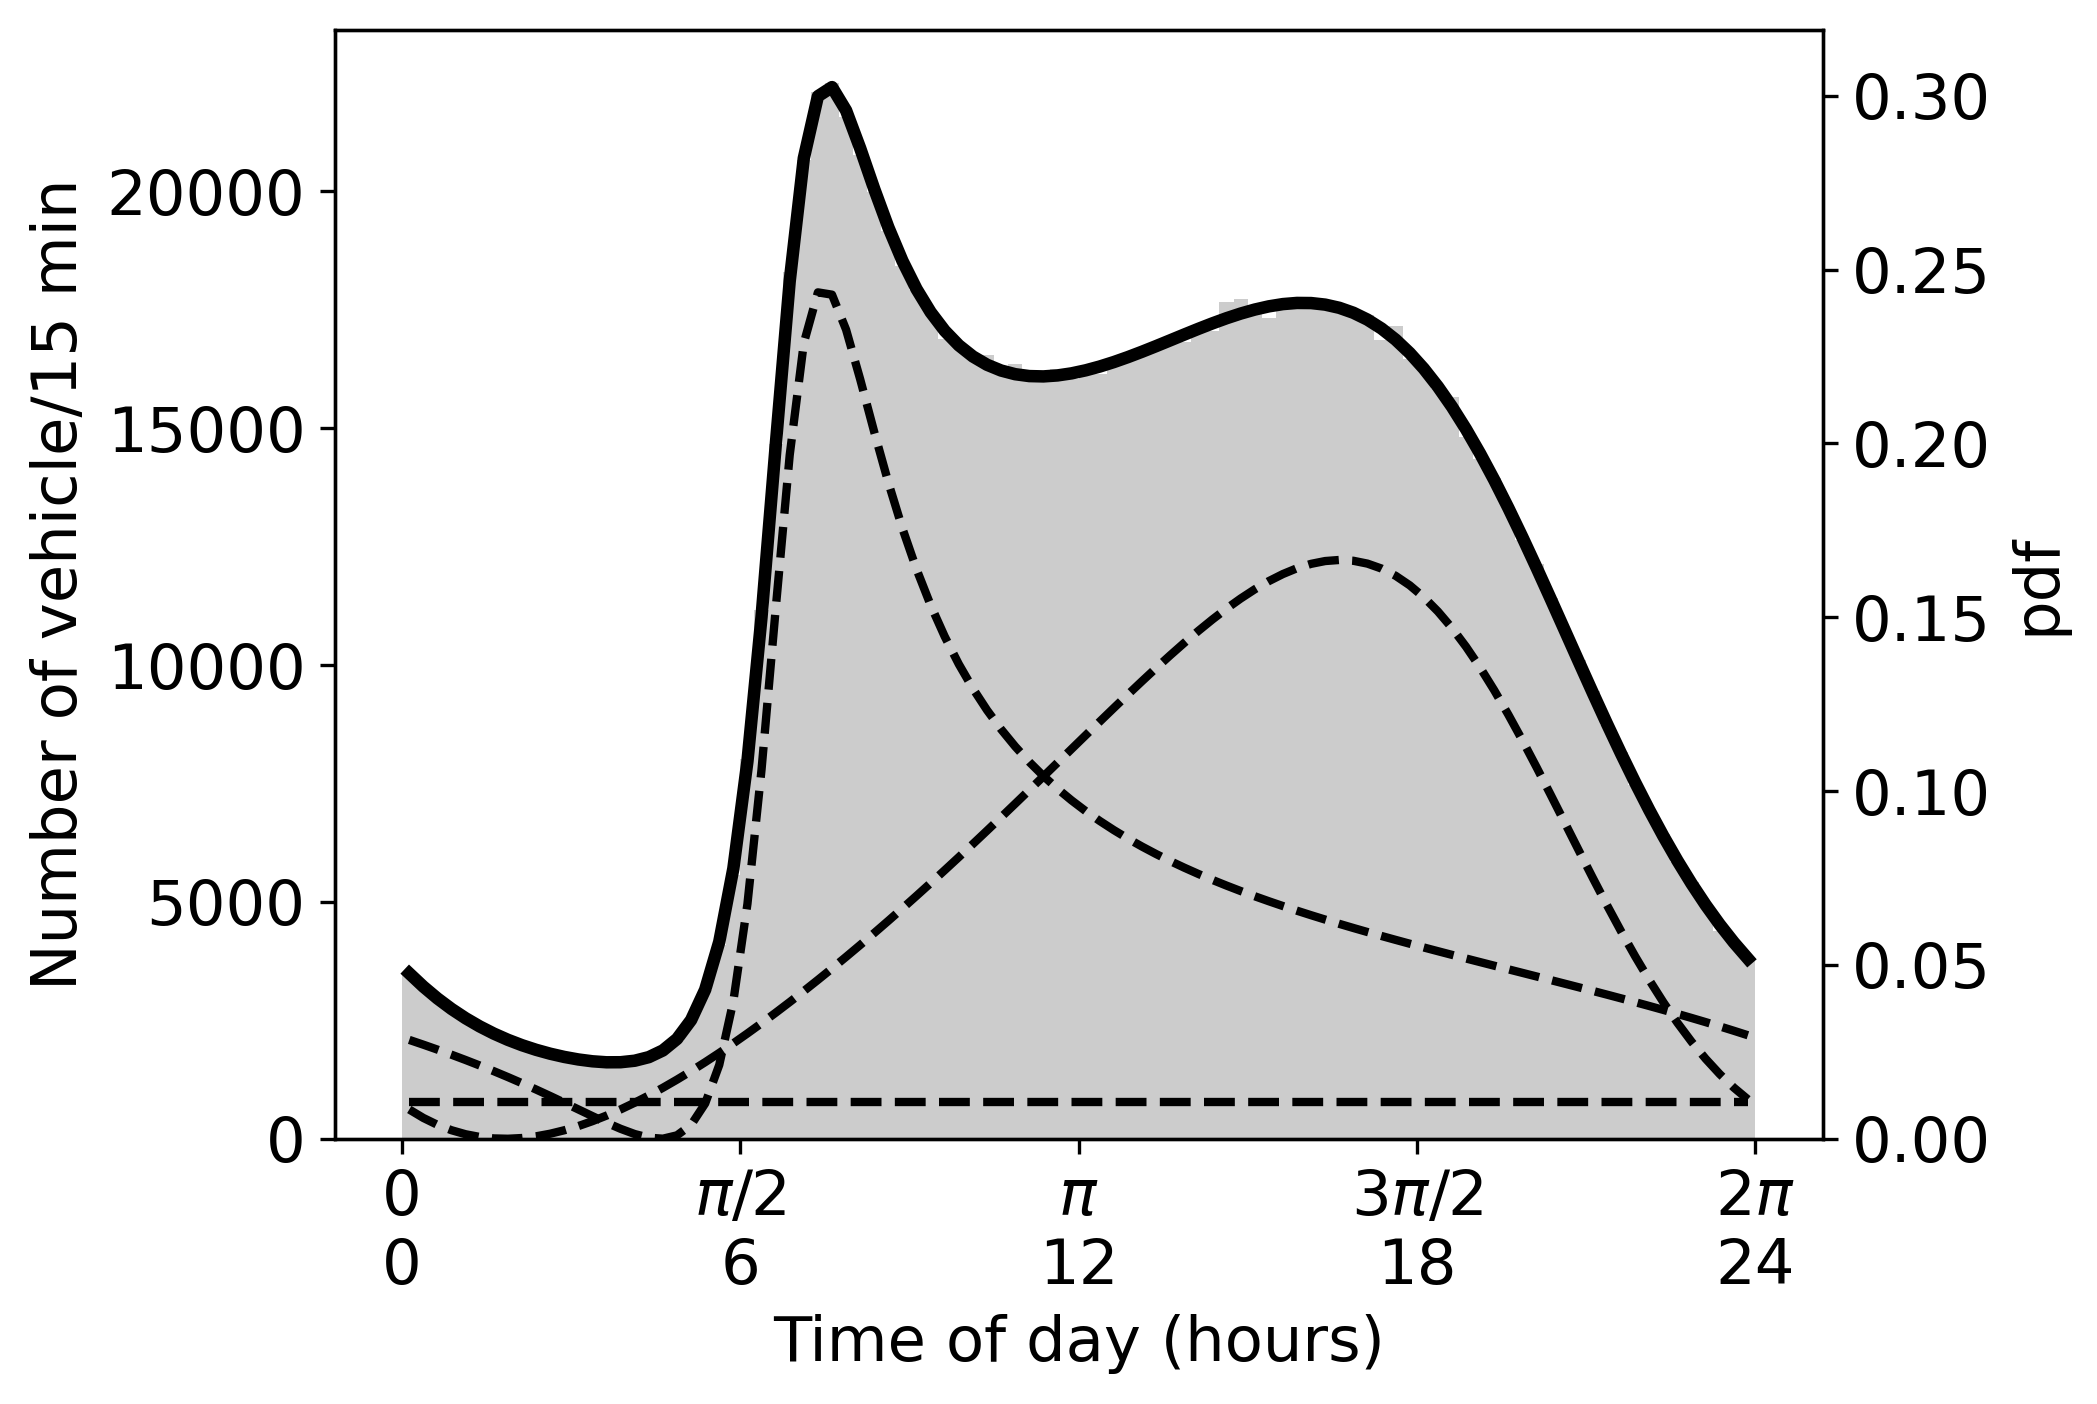

[[4.01515567 0.19967726 1.19467051 0.48462769]
 [2.75121491 0.72493427 5.32552606 0.44806699]]
---log-likelihood function--
-1839606.7900424202


C:\Users\Nagasaki\AppData\Local\Temp\ipykernel_35300\1849961966.py:134: RuntimeWarning: invalid value encountered in scalar divide
  gam=(1-x[1+3*k]**2)/(1-x[1+3*k]*math.cos(x[2+3*k]))


calculation time 294.24538254737854
---EM result---


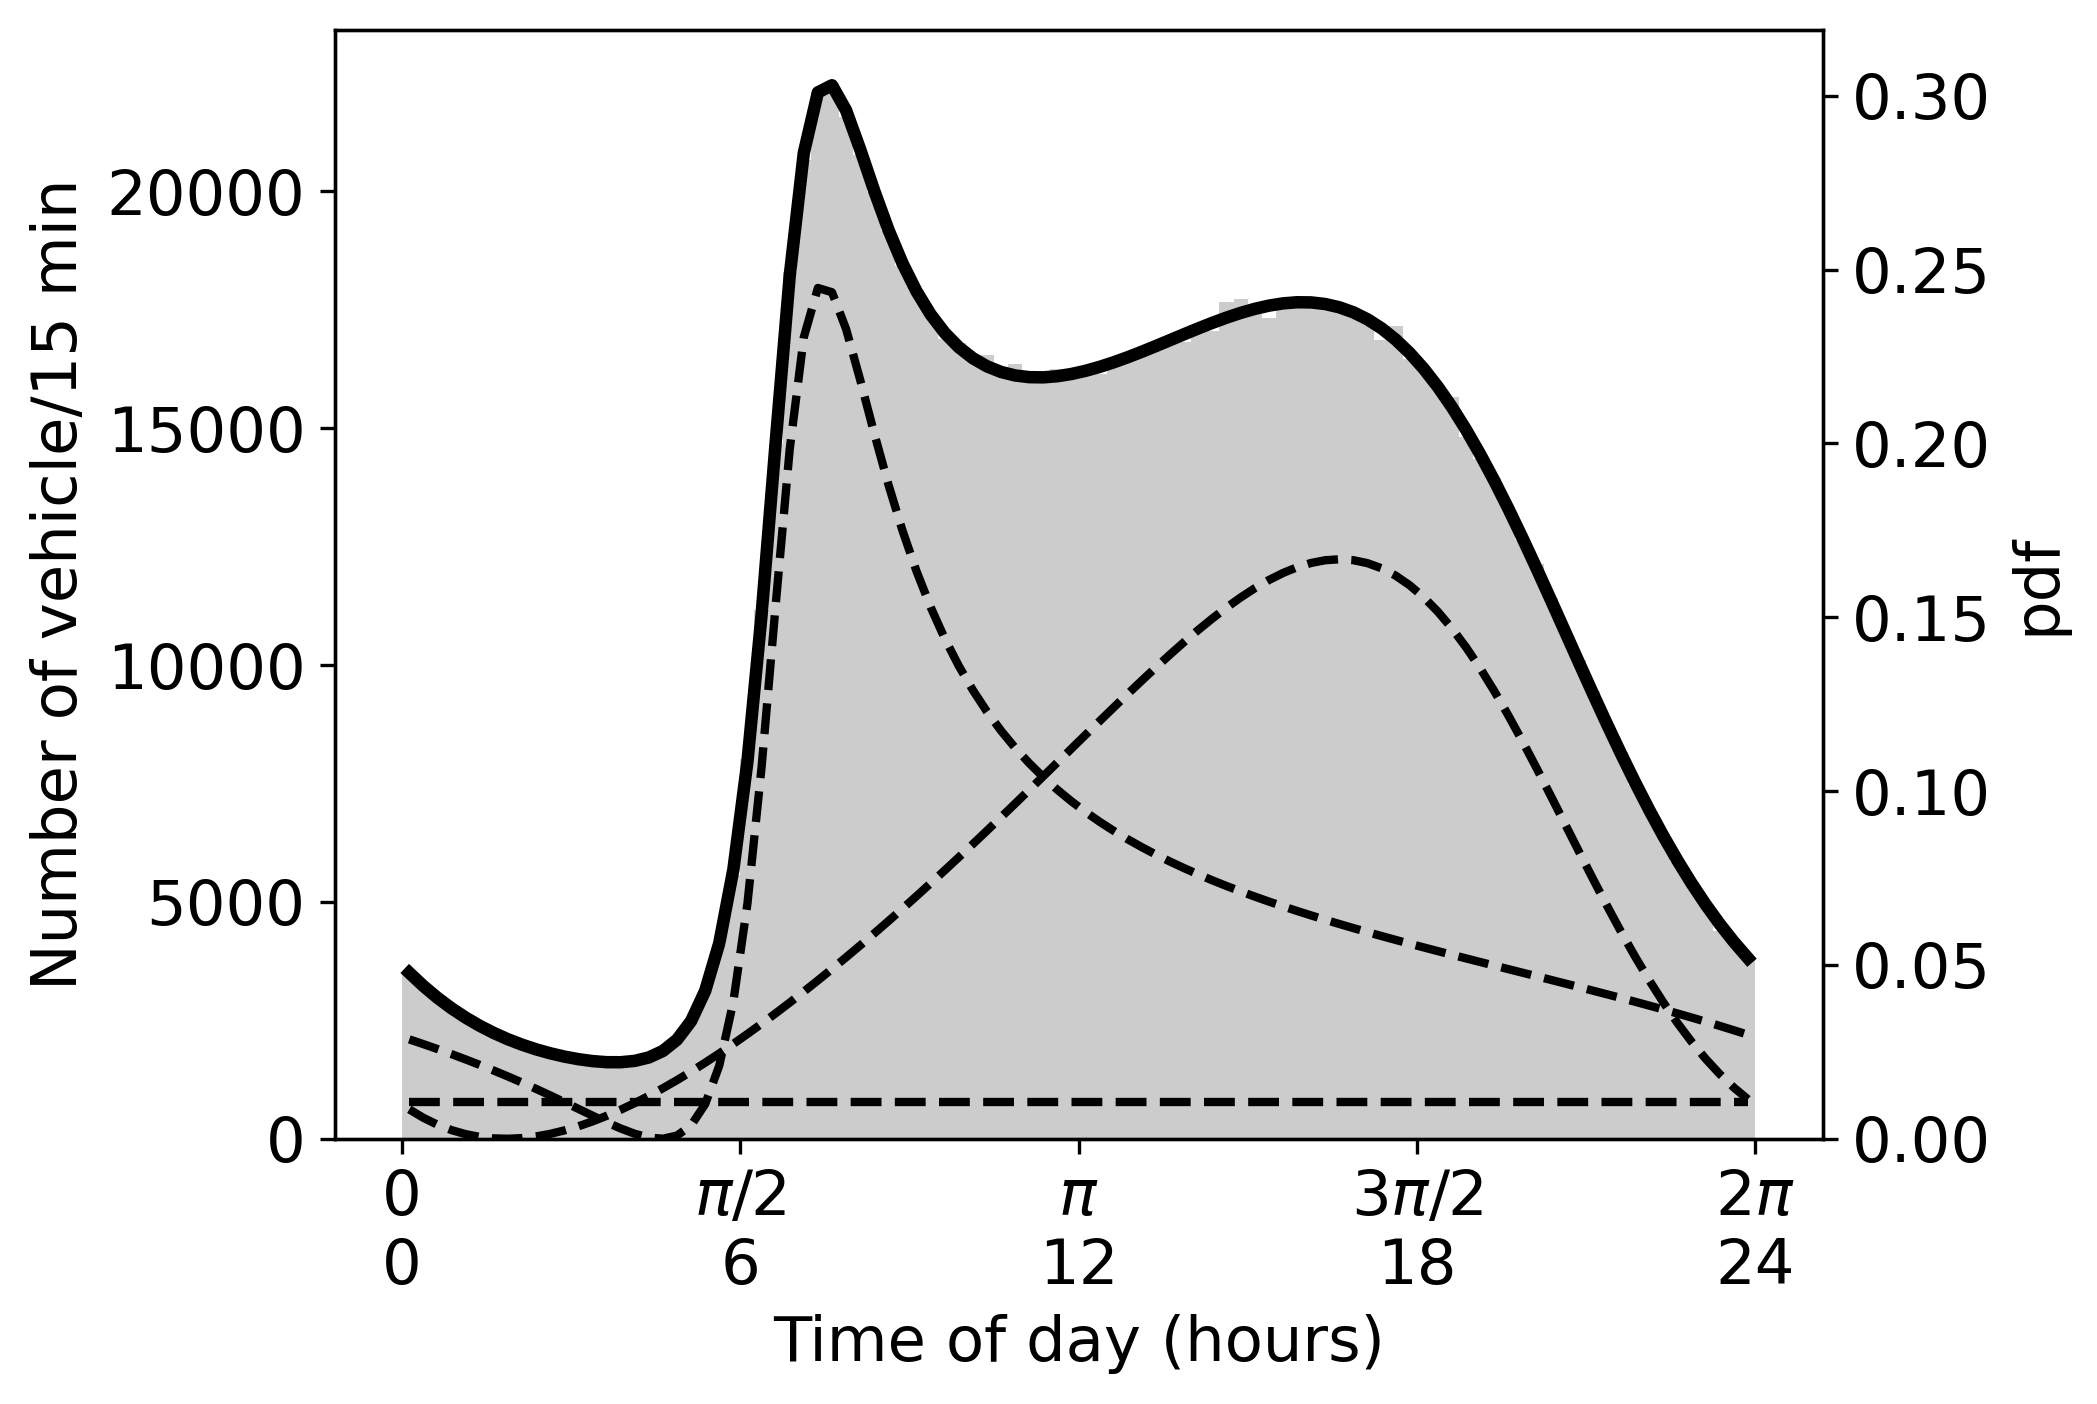

[[4.01471179 0.19860081 1.18616666 0.48459627]
 [2.74844705 0.72718053 5.32726873 0.44816884]]
---log-likelihood function--
-1839604.124037076


In [3]:
# moment of data
cosl=[sum([math.cos(p*angles[i]) for i in range(len(angles))])/len(angles) for p in range(q+1)]
sinl=[sum([math.sin(p*angles[i]) for i in range(len(angles))])/len(angles) for p in range(q+1)]

# define the bound for the optimizations
bound=[[-np.pi,2*np.pi],[0,1],[-np.pi,2*np.pi],[0,1]]*m
bounde=[[-np.pi,2*np.pi],[0,1],[-np.pi,2*np.pi]]*m

# numsuc is the number of trials for ETM optimization
numsuc=0
# bestres is the list for keeping best result, 1 is the initial value for comparison to the obtained result (updated immediately)
bestres=[1]


#Modified method of moment phase
startm=time.time()
while numsuc<1000:
    # Generate initial values for optimization of ETM
    x0=[]
    pis=[random.uniform(0,1) for k in range(m)]
    pis.extend([0,1])
    pis=sorted(pis)
    for k in range(m):
        mu=random.uniform(0,2*np.pi)
        rho=random.uniform(0,1)
        lam=random.uniform(0,2*np.pi)
        pi=pis[k+1]-pis[k]
        x0.extend([mu,rho,lam,pi])
        
    res=minimize(ETM,x0,bounds=bound, constraints=cons,method='SLSQP', tol=1.0e-10, options={'maxiter': 1000})
    
    if res.success==True:
        # if the value of ETM is smaller than the best value until this, the best result is updated
        if res.fun<bestres[0]:
            bestres=[res.fun,res]
        numsuc=numsuc+1
endm=time.time()
print("Calculation time",round(endm-startm,4))
x=bestres[1].x
# Modifying parameters within the domain
for k in range(m):
    x[4*k]=x[4*k]%(2*math.pi)
    x[2+4*k]=x[2+4*k]%(2*math.pi)
print("---ETM result---")
Drawing(x,m,angles_l)
print(np.array(x).reshape(m,4))


#EM phase
starte=time.time()
llh=-LogLH(x,m,angles)
print("---log-likelihood function--")
print(-llh)

roope=0
while roope<50:
    #E-step
    whole=PDF(x,m,angles)
    PDFs=np.array([eachPDF(x[4*k:4*(k+1)],angles) for k in range(m)])
    PDFs=np.vstack([PDFs,flatPDF(1-sum([x[3+4*k] for k in range(m)]),angles)])
    w_ki=PDFs/whole
    pi_k=[sum(w_ki[k])/len(angles) for k in range(m+1)]

    #M-step
    x_n=[]
    for k in range(m):
        x_n.extend(x[4*k:4*(k+1)-1])

    res=minimize(LogLHem,x_n,bounds=bounde,method='SLSQP', tol=1.0e-6, options={'maxiter': 1000})

    x_r=[]
    for k in range(m):
        x_r.extend(list(res.x[3*k:3*(k+1)])+[pi_k[k]])
    llh_=res.fun
    difllh=llh_-llh
    if difllh>-1:
        break
    llh=llh_
    x=x_r
    roope+=1
x=x_r
for k in range(m):
    x[4*k]=x[4*k]%(2*math.pi)
    x[2+4*k]=x[2+4*k]%(2*math.pi)
ende=time.time()
timee=ende-starte
print("calculation time",timee)
llh=LogLH(x,m,angles)
print("---EM result---")
Drawing(x,m,angles_l)
print(np.array(x).reshape(m,4))
print("---log-likelihood function--")
print(llh)